In [1]:
import data, model.unet, model.autoencoder, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch.utils.tensorboard as tb
import torchvision

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tb_writer = tb.SummaryWriter('log')

In [3]:
DEBUG=True

In [4]:
VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 64
CHANNELS = 3
STYLE_DIM = 256
BATCH_SIZE = 8
LOSS_TYPE = 'l1'

CONTENT_LOSS_WEIGHTS = {
    #'relu_1_1' : 1e-2,
    #'relu_4_2' : 5e-3,
    'relu_4_2' : 5e-1,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_2' : 1e2,
    'relu_2_2' : 1e2,
    'relu_3_2' : 5e2,
    'relu_4_2' : 1e1,
    'relu_5_2' : 1e1,
}
KLD_LOSS_WEIGHT = 1e-8

In [5]:
if DEBUG:
    data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
    data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
else:
    data_style = data.load_dataset('../dataset/style', resolution=RESOLUTION)
    data_content = data.load_dataset('../dataset/content', resolution=RESOLUTION)

In [6]:
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

In [7]:
CONTENT_DOWN_CONVOLUTIONS = 3
STYLE_DOWN_CONVOLUTIONS = 5

normalization = ['adain', 'adain', 'adain', 'adain', 'adain']
unet = model.unet.UNetAutoencoder(3, STYLE_DIM, residual_downsampling=True, residual_adain=True, residual_upsampling=True, 
        down_normalization='in', up_normalization='adain', num_adain_convolutions=4, 
        num_downup_convolutions=CONTENT_DOWN_CONVOLUTIONS, output_activation='sigmoid')
style_encoder = model.autoencoder.Encoder(2 * STYLE_DIM, num_down_convolutions=CONTENT_DOWN_CONVOLUTIONS)


loss_net = loss.LossNet()
_ = loss_net.eval()

In [8]:
if torch.cuda.is_available(): 
    unet = unet.cuda()
    style_encoder = style_encoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in unet.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)

In [9]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, min_lr=1e-6)

In [10]:
def forward(content_image, style_image):
    """ Forward pass through the architecture.
    
    Parameters:
    -----------
    content_image : torch.Tensor, shape [batch_size, 3, H, W]
        The content images.
    style_image : torch.Tensor, shape [batch_size, 3, H, W]
        The style images.
    
    Returns:
    --------
    stylized : torch.Tensor, shape [batch_size, 3, H, W]
        The stylizations.
    style_encoding : torch.Tensor, shape [batch_size, STYLE_DIM]
        Style encodings.
    style_encoding_mean : torch.Tensor, shape [batch_size, STYLE_DIM]
        Means for the style encodings.
    style_encoding_logvar : torch.Tensor, shape [batch_size, STYLE_DIM]
        Logarithm of the variances of the style encodings.
    """
    style_stats = style_encoder(style_image)
    style_mean = style_stats[..., : STYLE_DIM]
    style_logvar = style_stats[..., STYLE_DIM : ]
    style_sample = function.sample_normal(style_mean, style_logvar)
    stylized = unet(content_image, style_sample)
    return stylized, style_sample, style_mean, style_logvar

    0 / 15002: loss : 11.8531 -- perceptual loss : 1.1161 -- style loss : 10.7370 -- kld loss : 3445.7986
Validation...


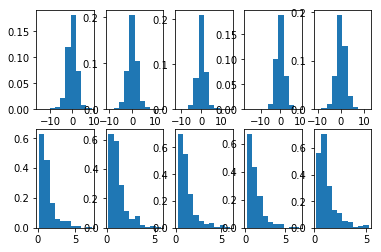


Average val loss: 12.89523983001709
Training with lr 0.0001...
  100 / 15002: loss : 8.8269 -- perceptual loss : 1.0629 -- style loss : 7.7640 -- kld loss : 3522.077601
Validation...


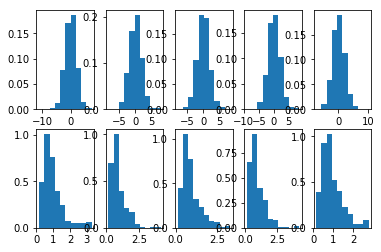


Average val loss: 9.983293533325195
Training with lr 0.0001...
  200 / 15002: loss : 8.3653 -- perceptual loss : 0.9905 -- style loss : 7.3748 -- kld loss : 3788.919905
Validation...


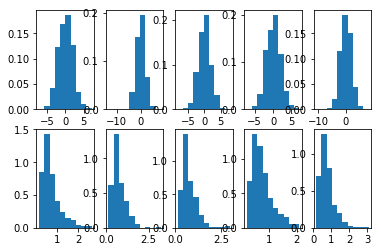


Average val loss: 9.399999618530273
Training with lr 0.0001...
  300 / 15002: loss : 7.0807 -- perceptual loss : 1.0095 -- style loss : 6.0712 -- kld loss : 4114.13775
Validation...


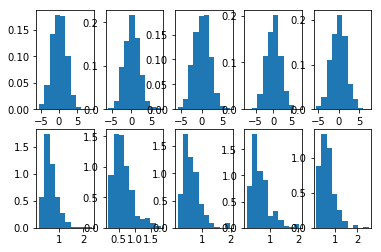


Average val loss: 8.410741806030273
Training with lr 0.0001...
  400 / 15002: loss : 6.9695 -- perceptual loss : 1.0456 -- style loss : 5.9238 -- kld loss : 4422.43417
Validation...


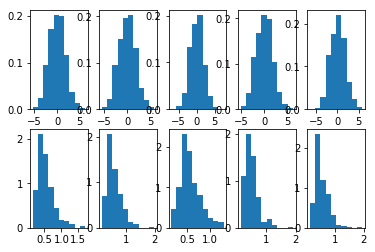


Average val loss: 8.483555793762207
Training with lr 0.0001...


KeyboardInterrupt: 

In [11]:
iteration = 0
val_step = 0
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: 
        break
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')
    
    unet.train(), style_encoder.train()
    optimizer.zero_grad()
    
    stylized, style_encoding, style_mean, style_logvar = forward(content_image, style_image)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS, loss=LOSS_TYPE)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS, loss=LOSS_TYPE)
    kld_loss = loss.kld_loss(style_mean, style_logvar)
    total_loss = perceptual_loss + style_loss + KLD_LOSS_WEIGHT * kld_loss
    total_loss.backward()
    optimizer.step()
    
    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train kld loss', kld_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f} -- kld loss : {kld_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        #tb_writer.add_images('train images', torch.from_numpy(np.concatenate([
        #    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        #])), iteration)
        # Validate
        print('\nValidation...')
        total_val_loss = 0.0
        with torch.no_grad():
            val_iteration = 0
            unet.eval(), style_encoder.eval()
            fig = plt.figure()
            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                
                if val_iteration >= VAL_ITERATIONS:
                    break
                    
                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')
                
                stylized, style_encoding, style_mean, style_logvar = forward(content_image, style_image)
                
                torch.set_printoptions(profile="full")
                #print(content_encoding)
                torch.set_printoptions(profile="default")
    
                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_stylized = loss_net(stylized)

                perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS, loss=LOSS_TYPE)
                style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS, loss=LOSS_TYPE)
                kld_loss = loss.kld_loss(style_mean, style_logvar)
                total_loss = perceptual_loss + style_loss + KLD_LOSS_WEIGHT * kld_loss
                total_val_loss += total_loss
                fig.add_subplot(2, VAL_ITERATIONS, val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().reshape(-1), density=True)
                fig.add_subplot(2, VAL_ITERATIONS, VAL_ITERATIONS + val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().std(0), density=True)
                
                tb_writer.add_scalar('validation loss', total_loss.item(), val_step)
                tb_writer.add_scalar('validation perceptual loss', perceptual_loss.item(), val_step)
                tb_writer.add_scalar('validation style loss', style_loss.item(), val_step)
                tb_writer.add_scalar('validation kld loss', kld_loss.item(), val_step)
                tb_writer.add_images('validation images', torch.from_numpy(np.concatenate([
                    img.detach().cpu().numpy() for img in [content_image, style_image, stylized]
                ])), val_step)
                val_iteration += 1
                val_step += 1
                print(f'\r{val_iteration:5d} / {VAL_ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f} -- kld loss : {kld_loss.item():.4f}', end='\r')
            
            plt.show()
            total_val_loss /= VAL_ITERATIONS
            print(f'\nAverage val loss: {total_val_loss}')
            lr_scheduler.step(total_val_loss)
            print(f'Training with lr {optimizer.param_groups[0]["lr"]}...')
            
            
    iteration += 1
    
    